In [1]:
%reset -f

import sys
sys.path.append('../code')

import utility

import numpy as np
import matplotlib.pyplot as plt
import kalman.filtering as flt

import pynumdiff

C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:972: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:1026: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:972: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\flyplotlib-0.0.1-py3.9.egg\fly_plot_lib\plot.py:1026: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\bcellini\Anaconda3\envs\wind-sense\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\bcellini\Anaconda3\en

## Model parameters

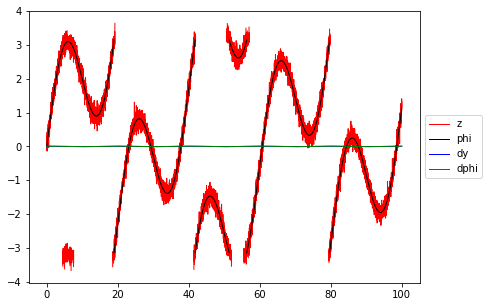

(10000,)


In [22]:
####### simulation parameters
np.random.seed(1)

kappa_y = 10 # precision of increment observations

T = 100 # simulation time
dt = 0.01 # step size
t = np.arange(0,T,dt)
kappa_phi = 1 # inverse diffusion constant
alpha = 10 # precision of direct observations, lin apprx
phi_0 = 0 # initial mean
kappa_0 = 20 # initial certainty
z = np.zeros(int(T/dt))

#### generate the trajectory and observations
# create hidden state trajectory and observation sequence
# phi, dy, z = flt.generateData(T,kappa_phi,kappa_y=kappa_y,alpha=alpha,dt=dt,phi_0=phi_0)

# phi = 0.0*(phi + 0.1*np.pi) + 0.5*t
# z = 0.0*(z + 0.1*np.pi) + 0.5*t
# dy = dy*0
# print(phi.shape)

A = 2
f = 0.05;
v = 0.2;
phi = v*t + A*np.sin(2*np.pi*f*t)
dphi = v + 2*np.pi*f*A*np.cos(2*np.pi*f*t)
dphi = dphi * dt

# dy = np.zeros(int(T/dt)) 
# for i in range(1,int(T/dt)):
#     dy[i] = np.random.normal(phi[i]-phi[i-1],0*1/np.sqrt(kappa_y) * np.sqrt(dt)) 
# plt.plot(t,dy)
# plt.plot(t,dphi)

# noise = np.random.normal(loc=0, scale=0*np.sqrt(1/50), size=len(phi))
noise = np.random.vonmises(mu=0, kappa=50, size=len(phi))
z = (phi + noise)
# dy = dphi + 0*noise
# dy = dy*0
phi = utility.wrapToPi(phi)
z = utility.wrapToPi(z)

# # z_unwrap = 1*t
# # z = flt.backToCirc(z_unwrap)

fig, (ax1) = plt.subplots(1,1,figsize=(7,5),sharex=True)
line1 = ax1.plot(*flt.circplot(t,z),linewidth=1,label=r'z', color='red')
line1 = ax1.plot(*flt.circplot(t,phi),linewidth=1,label=r'phi', color='black')
line1 = ax1.plot(*flt.circplot(t,dy),linewidth=1,label=r'dy', color='blue')
line1 = ax1.plot(*flt.circplot(t,dphi),linewidth=1,label=r'dphi', color='green')

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
plt.show()

print(phi.shape)


## Filtering algorithms
### Von Mises Projection Filter

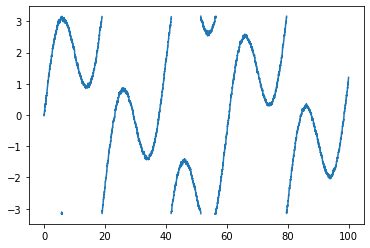

In [23]:
mu_VM, kappa_VM = flt.vM_Projection_Run(T,kappa_phi,z=z,alpha=alpha,dy=dy,kappa_y=kappa_y,
                        phi_0=phi_0,kappa_0=kappa_0,dt=dt)

plt.plot(*flt.circplot(t,mu_VM))
# plt.plot(t,mu_VM)

### Gauss ADF

In [24]:
# mu_G, kappa_G = flt.GaussADF_run(T,kappa_phi,z=z,alpha=alpha,dy=dy,kappa_y=kappa_y,phi_0=phi_0,kappa_0=kappa_0,dt=dt)

### Particle filter (benchmark)

In [25]:
# N = 10000
# mu_PF, r_PF = flt.PF_run(T,N,kappa_phi,z=z,alpha=alpha,dy=dy,kappa_y=kappa_y,phi_0=phi_0,kappa_0=kappa_0,dt=dt)

## Figure 1a

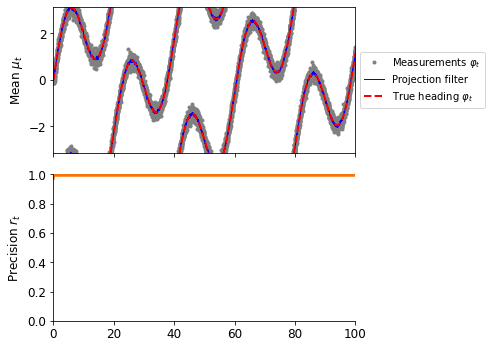

In [27]:
plt.rcParams.update({'font.size': 12})

col_PF = 'xkcd:green'
col_ADF = 'xkcd:blue'
col_vM = 'xkcd:orange'

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,5),sharex=True)

line1 = ax1.plot(*flt.circplot(t,z),'.',linewidth=1,label=r'Measurements $\varphi_t$', color='gray')
line2 = ax1.plot(*flt.circplot(t,mu_VM),linewidth=1,label=r'Projection filter',color='blue')
line3 = ax1.plot(*flt.circplot(t,phi),'--',linewidth=2,label=r'True heading $\varphi_t$', color='red')
# line3 = ax1.plot(*flt.circplot(t,mu_G),linewidth=2,label=r'Gauss filter',color=col_ADF)
# line4 = ax1.plot(*flt.circplot(t,mu_PF),'--',linewidth=2,label=r'Particle Filter',color=col_PF)

ax1.set_xlim([0,T])
#ax1.set_ylim([-np.pi,np.pi])
ax1.set_ylabel(r'Mean $\mu_t$')
# ax1.set_yticks([0., - np.pi, np.pi])
# ax1.set_yticklabels(["$0$",r"$-\pi$",r"$\pi$"])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
ax1.set_ylim([-np.pi, np.pi])

ax2.plot(t,flt.A_Bessel(kappa_VM),linewidth=3,label=r'Projection filter',color=col_vM)
# ax2.plot(t,flt.A_Bessel(kappa_G),linewidth=3,label=r'Gauss filter',color=col_ADF)
# ax2.plot(t,r_PF,'--',linewidth=3,label=r'Particle Filter',color=col_PF)
# ax2.set_xlabel(r'$t/\kappa_{\varphi}$')

ax2.set_xlim([0,T])
ax2.set_ylim([0,1])
ax2.set_ylabel(r'Precision $r_t$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.1)

fig.tight_layout()
plt.show()